In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis
import pingouin as pg

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

import networkx as nx
import community.community_louvain as community_louvain # pip install community

In [2]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

## Classify

In [3]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe


In [4]:
def run_pca(feature_arr):
    dataframe = pd.DataFrame(index=range(len(feature_arr)),columns=range(len(feature_arr[0])))
    for i in range(len(feature_arr)):
        dataframe.iloc[i]=feature_arr[i]
        
    x=dataframe.loc[:,dataframe.columns.values].values
    
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    return principalComponents

def box_cox_transform(dataframe):
    fitted_ef, fitted_lambda1 = stats.boxcox(dataframe.mean_ef)
    dataframe.mean_ma=dataframe.mean_ma+0.1
    fitted_ma, fitted_lambda2 = stats.boxcox(dataframe.mean_ma)
    fitted_wd, fitted_lambda3 = stats.boxcox(dataframe.length_of_encounter)
    fitted_mc, fitted_lambda3 = stats.boxcox(dataframe.mean_concentration)
    dataframe.std_whiff=dataframe.std_whiff+0.1
    fitted_sw, fitted_lambda3 = stats.boxcox(dataframe.std_whiff)
    dataframe['mean_ef']=fitted_ef
    dataframe['mean_ma']=fitted_ma
    dataframe['log_whiff']=fitted_wd
    dataframe['std_whiff']=fitted_mc
    dataframe['mean_concentration']=fitted_sw
    
def remove_motion_effect(dataframe):
    whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    moving_avg = smf.ols(formula='whiff_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()
    sw = smf.ols(formula='std_whiff ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dataframe).fit()


    dataframe['log_whiff']=whiff_duration.resid
    dataframe['mean_ef'] = whiff_frequency.resid
    dataframe['whiff_ma'] = moving_avg.resid
    dataframe['mean_concentration'] = mc.resid
    dataframe['std_whiff'] = sw.resid

In [5]:
def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
            
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff


def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T):
    for i in range(500):
        xx,dx,n,t=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        
    return X,y,D,N,T

In [49]:
# df_windy=create_class_column_fullts(pd.read_hdf(dir+'Windy/WindyMASigned.h5'))
# df_notwindy=create_class_column_fullts(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
# df_forest=create_class_column_fullts(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

# fdf_windy = create_class_column_log(pd.read_hdf(dir+'Windy/WindyMASigned_6.h5'))
# fdf_notwindy = create_class_column_log(pd.read_hdf(dir+'NotWindy/NotWindyMASigned_6.h5'))
# fdf_forest = create_class_column_log(pd.read_hdf(dir+'Forest/ForestMASigned_6.h5'))

fdf_windy=pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf_notwindy=pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf_forest=pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

### Collect Train & Test features



In [169]:
lookback_time = 10

desert = pd.concat([fdf_notwindy,fdf_windy,fdf_forest])
desert.reset_index(inplace=True, drop=True)
trainset= fdf_forest
testset=fdf_forest

D_train=[]
D_test=[]
mean_time_train=[]
mean_time_test=[]
Xtest = []
ytest = []
Xtrain = []
ytrain = []
Nrows_train = []
Nrows_test = []

for distance_class in [0,1]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)
    
# for distance_class in [0,1]:
#     Xtest, ytest, D_test,Nrows_test,mean_time_test = gather_stat_timed(testset,distance_class,
#                       lookback_time, Xtest,ytest,D_test,Nrows_test,
#                       mean_time_test)
    

In [170]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

In [171]:
# parameters=['mc_mean','ma_std_dev', 'ma_max' ,'wd_std_dev']

In [172]:
# # r2=pd.DataFrame()
# rsq=[]
# # Fit models and store R-squared values
# for parameter in parameters:
#     formula = f"distance ~ {parameter}"
#     model = smf.ols(formula=formula, data=traindf).fit()
#     rsq.append( model.rsquared)

In [173]:
# r2['forest']=rsq

In [174]:
# distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
# wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
# ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

# print(format(distance.f_pvalue, '.80f'))

distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
# distance=smf.ols(formula=""" distance ~ wd_std_dev """, data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     57.68
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           1.65e-43
Time:                        09:48:38   Log-Likelihood:                -2190.3
No. Observations:                 935   AIC:                             4391.
Df Residuals:                     930   BIC:                             4415.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.2144      0.617     23.036      0.0

In [175]:
# val=pd.DataFrame(columns=['model_intercept','mc_mean','ma_std','ma_max', 'wd_std'])
val=pd.DataFrame()

In [176]:
val['r2']=['mc_mean','ma_std','ma_max', 'wd_std']

In [178]:
val['r2_hws']=[ 0.70,0.041,0.081,0.045]
val['r2_lws']=[ 0.43,0.015,0.021,0]
val['r2_forest']=[ 0.22,0.01,0.01,0.008]

,r2,r2_hws,r2_lws,r2_forest
0,mc_mean,0.700,0.430,0.220
1,ma_std,0.041,0.015,0.010
2,ma_max,0.081,0.021,0.010
3,wd_std,0.045,0.000,0.008
4,overall,0.710,0.440,0.230


In [65]:
# val.loc[2] = distance.params.values

##### All Regression Model
distance = -8.85 * $\mu(WC)$ + 0.20 * max(WMA) - 2.43 * $\sigma(WMA)$ - 3.07 * $\sigma(WD)$ + 84.40
##### HWS
distance = -10.74 * $\mu(WC)$ - 0.63 * max(WMA) + 1.16 * $\sigma(WMA)$ - 7.45 * $\sigma(WD)$ + 102.47
##### LWS
distance = -7.59 * $\mu(WC)$ + 0.52 * max(WMA) - 0.82 * $\sigma(WMA)$ - 7.92 * $\sigma(WD)$ + 73.24
##### Forest
distance = -1.3 * $\mu(WC)$ + 0.09 * max(WMA) - 0.06 * $\sigma(WMA)$ - -0.53 * $\sigma(WD)$ + 15.05

### Wind Characterization vs AIC Filter Whiff parameters

In [132]:
std_wind_dir = np.array([8.17,27.03,44.94])
turb_intensity_val=np.array([0.14,0.36,0.54]) #hws , lws, forest
env = np.array(['hws', 'lws', 'forest'])

#### Model Intercepts

In [200]:
val=pd.read_hdf(dir+'aic_filtered_model_params.h5')

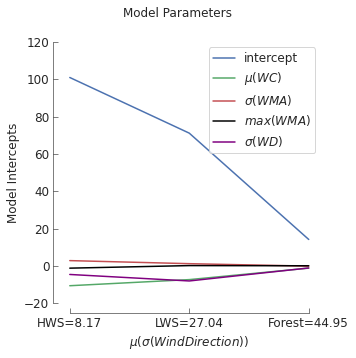

In [201]:
f,ax = plt.subplots(1,1,figsize=(5,5))

ax.grid(False)
xaxis=np.array([0,0.5,1])
ax.plot(xaxis,val.transpose().iloc[0].values,c='b',label='intercept')
ax.plot(xaxis,val.transpose().iloc[1].values,c='g',label='$\mu(WC)$')
ax.plot(xaxis,val.transpose().iloc[2].values,c='r',label='$\sigma(WMA)$')
ax.plot(xaxis,val.transpose().iloc[3].values,c='black',label='$max(WMA)$')
ax.plot(xaxis,val.transpose().iloc[4].values,c='purple',label='$\sigma(WD)$')


mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5}, 
                            smart_bounds=True,   
                            xticks=[0,0.5,1],
                            # yticks=[0,0.2,0.5,0.7],
                            linewidth=0.5)

ax.set_xticklabels(['HWS=8.17','LWS=27.04','Forest=44.95'],rotation=0)

ax.legend(loc='upper right')
ax.set_ylabel('Model Intercepts')
ax.set_xlabel('$\mu(\sigma(Wind Direction))$')
f.suptitle("Model Parameters")

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 12)
# f.savefig('../../Figure/TiWindSpeedR2WD.jpeg', dpi=300, bbox_inches = "tight")

#### Individual R2

In [ ]:
val=pd.read_hdf(dir+'aic_filtered_model_r2.h5')

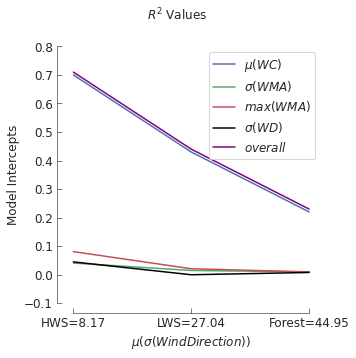

In [199]:
f,ax = plt.subplots(1,1,figsize=(5,5))

ax.grid(False)
xaxis=np.array([0,0.5,1])
ax.plot(xaxis,val.iloc[0][1:],c='b',label='$\mu(WC)$')
ax.plot(xaxis,val.iloc[1][1:],c='g',label='$\sigma(WMA)$')
ax.plot(xaxis,val.iloc[2][1:],c='r',label='$max(WMA)$')
ax.plot(xaxis,val.iloc[3][1:],c='black',label='$\sigma(WD)$')
ax.plot(xaxis,val.iloc[4][1:],c='purple',label='$overall$')

# ax.plot(xaxis,val.iloc[0][1:],'o',c='b')
# ax.plot(xaxis,val.iloc[1][1:],'o',c='g')
# ax.plot(xaxis,val.iloc[2][1:],'o',c='r')


mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5}, 
                            smart_bounds=True,   
                            xticks=[0,0.5,1],
                            # yticks=[0,0.2,0.5,0.7],
                            linewidth=0.5)

ax.set_xticklabels(['HWS=8.17','LWS=27.04','Forest=44.95'],rotation=0)

ax.legend(loc='upper right')
ax.set_ylabel('Model Intercepts')
ax.set_xlabel('$\mu(\sigma(Wind Direction))$')
f.suptitle("$R^2$ Values")

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 12)
# f.savefig('../../Figure/TiWindSpeedR2WD.jpeg', dpi=300, bbox_inches = "tight")

In [39]:
# aic_filtered_names=['mc_mean','ma_std_dev','ma_max','wd_std_dev']
# y=traindf.distance
# x=traindf.loc[traindf.distance.notnull(), aic_filtered_names].values
# x = sm.add_constant(x)
# x[np.isnan(x)] =0
# olsmod = sm.OLS(y, x)
# olsres = olsmod.fit()
# ypred = olsres.predict(x)
# print(olsres.rsquared)

0.23006284525415732


### Semi Partial Correlation Coefficient

In [49]:
traindf['predicted_distance']=ypred

In [61]:
traindf.to_hdf('~/DataAnalysis/data/Sprints/HighRes/KF/AllpredictionFiltered.h5', key='traindf', mode='w')

In [35]:
# Define the response variable and predictor variables
col = ['mc_mean','ma_std_dev','ma_max','wd_std_dev','distance']

df = traindf[col]
df.fillna(0, inplace=True)

# Calculate the semi-partial correlation for each predictor and square it
part_corr_squared = [pg.partial_corr(data=df, x=col, y='distance', 
                                     covar=df.columns.drop([col, 'distance']).tolist()).r**2 for col in df.columns[:-1]]

# Fit the multiple regression model to calculate the R-squared value
model = sm.OLS(df['distance'], sm.add_constant(df[df.columns[:-1]])).fit()
r_squared = model.rsquared

# Calculate the percentage contribution of each predictor
percentage_contributions = (part_corr_squared / r_squared) * 100

# Print the percentage contributions
for i, predictor in enumerate(df.columns[:-1]):
    print(f"Percentage contribution of {predictor}: {percentage_contributions[i][0]:.2f}%")


Percentage contribution of mc_mean: 84.88%
Percentage contribution of ma_std_dev: 1.93%
Percentage contribution of ma_max: 0.06%
Percentage contribution of wd_std_dev: 0.12%
Percentage contribution of wf_std_dev: 3.87%


In [49]:
testdf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtest)):
    if(np.size(Xtest[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtest[i])):
            X.append(calc_val(Xtest[i][j]))
        testdf.loc[i]=np.ravel(X)
testdf['distance']=np.delete(D_test, c1)
testdf['mean_whiff_time'] = np.delete(mean_time_test, c1)
testdf['nwhiffs'] = np.delete(Nrows_test, c1)

In [50]:
# Predicting on the test data
x_test = testdf.loc[testdf.distance.notnull(), column_names].values
x_test = sm.add_constant(x_test)
x_test[np.isnan(x_test)] = 0

# use the trained model to predict on the test set
ypred_test = olsres.predict(x_test)


### Semi Partial Correlation Coeff - calculated


In [10]:
# Define the response variable
Y = traindf.distance

# Define the predictor variables and replace missing values with zeros
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']
X = traindf[column_names]
X.fillna(0, inplace=True)

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(Y, X).fit()

# Calculate the total R-squared value
r_squared = model.rsquared

# Calculate the squared semi-partial correlation for each predictor
part_corr_squared = np.zeros(X.shape[1] - 1)  # Minus 1 because of the constant
for i in range(1, X.shape[1]):  # Start at 1 because of the constant
    X_reduced = X.drop(X.columns[i], axis=1)
    model_reduced = sm.OLS(Y, sm.add_constant(X_reduced)).fit()
    part_corr_squared[i-1] = (model_reduced.ssr - model.ssr) / model.centered_tss

# Calculate the percentage contribution of each predictor
percentage_contributions = (part_corr_squared / r_squared) * 100

# # Print the percentage contributions
# for i, predictor in enumerate(column_names):
#     print(f"Percentage contribution of {predictor}: {percentage_contributions[i]:.2f}%")


### Semi Partial Correlation Coeff - Using Pingouin

In [21]:
# Define the response variable and predictor variables
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k', 'distance']


df = traindf[column_names]
df.fillna(0, inplace=True)

# Calculate the semi-partial correlation for each predictor and square it
# part_corr_squared = [pg.partial_corr(data=df, x=col, y='distance', covar=df.columns.drop([col, 'distance']).tolist()).r**2 for col in df.columns[:-1]]
# Calculate the semi-partial correlation for each predictor and square it
part_corr_squared = [pg.partial_corr(data=df, x=col, y='distance', covar=df.columns.drop([col, 'distance']).tolist()).r.values[0]**2 for col in df.columns[:-1]]

# Fit the multiple regression model to calculate the R-squared value
model = sm.OLS(df['distance'], sm.add_constant(df[df.columns[:-1]])).fit()
r_squared = model.rsquared

# Calculate the percentage contribution of each predictor
percentage_contributions = np.array(part_corr_squared) / r_squared * 100


# Create a DataFrame to store the predictor names and their corresponding percentage contributions
contrib_df = pd.DataFrame({
    'Predictor': df.columns[:-1],
    'Percentage Contribution': percentage_contributions
})

contrib_df


,Predictor,Percentage Contribution
0,mc_min,1.980044
1,mc_max,2.034970
2,mc_mean,20.921257
3,mc_std_dev,2.215876
4,mc_k,0.000002
5,wf_min,0.018614
6,wf_max,0.689038
7,wf_mean,0.001882
8,wf_std_dev,2.035587
9,wf_k,0.060093


In [26]:
contrib_df.loc[np.where(contrib_df['Percentage Contribution']>2)]

,Predictor,Percentage Contribution
1,mc_max,2.034970
2,mc_mean,20.921257
3,mc_std_dev,2.215876
8,wf_std_dev,2.035587


## Linear Distance Analysis - OLS


### Calculate statistics of timed train and test data

In [11]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
#     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

## Done separately because Forest dataset has two classes
## Training set
traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)


In [12]:
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)
# traindf['mean_concentration_continuous'] = np.delete(MCTrain, c1)


In [56]:
# traindf.to_hdf(dir+'Desert/WindyTrainDf.h5', key='combtest', mode='w')

### $AIC$ and $R^2$

In [18]:
# df1 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_1.h5')
# df2 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_3.h5')
# df3 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_5.h5')
# df4 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_10.h5')
# df5 = pd.read_hdf(dir+'R2_AIC/TimeTest/all_Rsquared_20.h5')
# df = pd.read_hdf(dir+'R2_AIC/TimeTest/hws_Rsquared_6v.h5')
df = pd.read_hdf(dir+'R2_AIC/all_Rsquared.h5')

# aic = pd.read_hdf(dir+'Windy/Desert_Aic.h5')

Text(2, 0.1, '$R^2$=0.05')

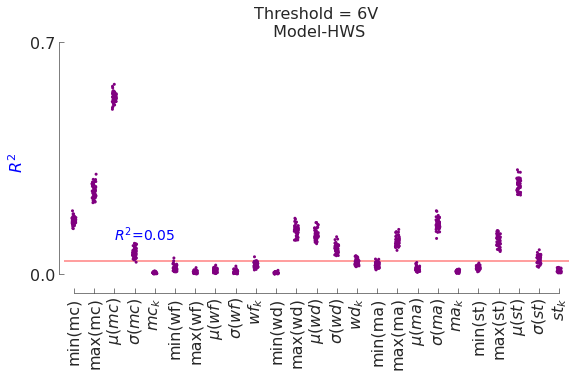

In [19]:
f,ax=plt.subplots(1,1,figsize=(8,5))
# sns.stripplot(data=df1, ax=ax, dodge=True, size=3, color='Black',label='LT=1sec',rasterized=True)
# sns.stripplot(data=df2, ax=ax, dodge=True, size=3, color='Green',label='LT=3sec',rasterized=True)
# sns.stripplot(data=df3, ax=ax, dodge=True, size=3, color='Blue',label='LT=5sec',rasterized=True)
# sns.stripplot(data=df4, ax=ax, dodge=True, size=3, color='Red',label='LT=10sec',rasterized=True)
sns.stripplot(data=df, ax=ax, dodge=True, size=3, color='Purple',label='LT=20sec',rasterized=True)
ax.grid(False)
label=['min(mc)','max(mc)','$\mu(mc)$','$\sigma(mc)$', '$mc_k$',
      'min(wf)','max(wf)','$\mu(wf)$','$\sigma(wf)$', '$wf_k$',
      'min(wd)','max(wd)','$\mu(wd)$','$\sigma(wd)$', '$wd_k$',
      'min(ma)','max(ma)','$\mu(ma)$','$\sigma(ma)$', '$ma_k$',
      'min(st)','max(st)','$\mu(st)$','$\sigma(st)$', '$st_k$']
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(0.04, color = 'red', alpha=0.5)
ax.set_ylabel('$R^2$',c='blue')

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left': 5}, 
                            smart_bounds=True,                            
                            yticks=[0,0.7],
                            linewidth=0.5)
ax.set_xticklabels(label, rotation=90)
# ax.set_title('Bootstrapped $R^2$ Desert')
ax.set_title('Threshold = 6V\n Model-HWS')

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
ax.text(2,0.1,'$R^2$=0.05',color='black',fontsize='14',c='blue')
# f.savefig('../../Figure/community6vhws.jpeg', dpi=300, bbox_inches = "tight")

In [20]:
col_name=[]
for i in range(len(df.columns)):
    if (df.iloc[:,i].max() >= 0.05):
        col_name.append(df.columns[i])
        
col_name

['mc_min',
 'mc_max',
 'mc_mean',
 'mc_std_dev',
 'wf_k',
 'wd_max',
 'wd_mean',
 'wd_std_dev',
 'wd_k',
 'ma_max',
 'ma_std_dev',
 'st_max',
 'st_mean',
 'st_std_dev']

In [21]:
import itertools
column_names=col_name
rsquaredres=[]
aicres=[]
para_list = []
# pval=[]
# bicres=[]

for i in range(1,10):
    sub_parameter_list = list(itertools.combinations(column_names,i))
  
    for elements in sub_parameter_list:
        para_list.append(elements)
        y=traindf.distance
        x = sm.add_constant(traindf.loc[traindf.distance.notnull(), elements].values)
        olsmod = sm.OLS(y, x)
        olsres = olsmod.fit()
        rsquaredres.append(olsres.rsquared)
        aicres.append(olsres.aic)
#         pval.append(olsres.f_pvalue)
#         bicres.append(olsres.bic)
        
combtest=pd.DataFrame()
combtest['rsquared']=rsquaredres
combtest['aic']=aicres
combtest['parameters']=para_list
# combtest['fpvalue']=pval
# combtest['bic']=bicres


combtest['n_para']=np.zeros(len(combtest))
for i in range(len(combtest)):
    combtest.n_para[i]=len(combtest.parameters[i])

In [23]:
combtest.to_hdf(dir+'R2_AIC/R2_AllRsquaredAicCombinations.h5', key='combtest', mode='w')
# combtest.loc[(np.where(combtest.n_para==1))].sort_values(by=['aic'],ascending=True)

/tmp/ipykernel_39096/2901401479.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['parameters'], dtype='object')]

  combtest.to_hdf(dir+'R2_AIC/R2_AllRsquaredAicCombinations.h5', key='combtest', mode='w')


In [24]:
aic_min=[]
for i in range(1,int(combtest.n_para.max()+1)):
    aic_min.append(np.min(combtest.aic.iloc[(np.where(combtest.n_para==i))]))

aic_delta=[]
for i in range(len(aic_min)):
    if i ==0:
        aic_delta.append(0)
    else:
        aic_delta.append(aic_min[i]-aic_min[i-1])
        
aic_table=pd.DataFrame()
aic_table['aic_min'] = aic_min
aic_table['aic_delta']=aic_delta
aic_table

,aic_min,aic_delta
0,10726.214462,0.000000
1,10655.888392,-70.326070
2,10631.153469,-24.734924
3,10594.504445,-36.649023
4,10575.051043,-19.453402
5,10557.273957,-17.777086
6,10532.499716,-24.774241
7,10529.417901,-3.081815
8,10524.601633,-4.816268


In [25]:
aic_table.to_hdf(dir+'R2_AIC/All_AicDeltaTab.h5', key='aic_table', mode='w')

In [131]:
for i in range(1,len(aic_table)):
#     print(i)
    print(*(combtest.parameters[combtest.aic==(combtest.aic.loc[(np.where(combtest.n_para==i))]).min()]))

('mc_mean',)
('mc_mean', 'ma_std_dev')
('mc_mean', 'ma_max', 'ma_std_dev')
('mc_mean', 'wd_std_dev', 'ma_max', 'ma_std_dev')
('mc_max', 'mc_mean', 'wd_std_dev', 'ma_max', 'ma_std_dev')
('mc_min', 'mc_max', 'mc_mean', 'wd_std_dev', 'ma_max', 'ma_std_dev')
('mc_min', 'mc_max', 'mc_mean', 'mc_k', 'wd_std_dev', 'ma_max', 'ma_std_dev')
('mc_min', 'mc_max', 'mc_mean', 'mc_k', 'wd_std_dev', 'ma_max', 'ma_mean', 'ma_std_dev')


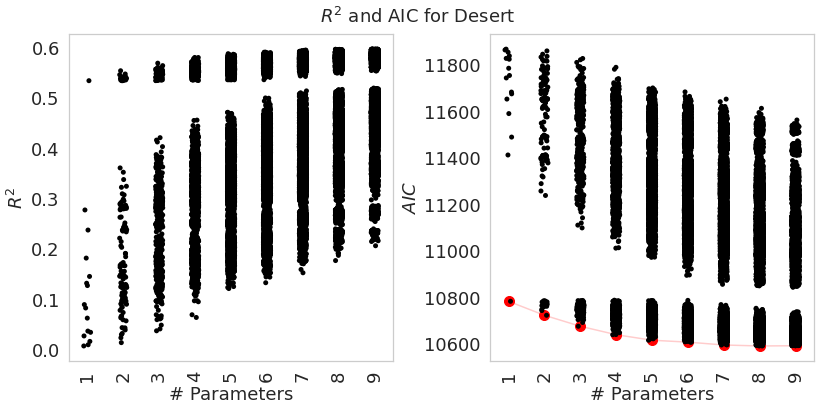

In [17]:
f,(ax,ax1)=plt.subplots(1,2,figsize=(12,6))
ax.grid(False)
ax.set_ylabel('$R^2$')
sns.stripplot(x=combtest.n_para,y=combtest.rsquared,data=combtest, 
              ax=ax, color='black',
              dodge=True, size=5)

ax.set_ylabel('$R^2$')
ax.set_xlabel('# Parameters')
ax.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)
# ax.set_title('$R^2$')

sns.stripplot(x=combtest.n_para,y=combtest.aic, data=combtest, color='black',
              ax=ax1,dodge=True, size=5)
ax1.set_xlabel('# Parameters')
ax1.set_ylabel('$AIC$')
ax1.grid(False)p.ma.log2(probs)).sum()
​
    return info
​
mutual_info(traindf.mc_mean,traindf.wd_mean)
/tmp/ipykernel_136646/267784704.py:13: RuntimeWarning: invalid value encountered in true_divide
  probs = joint_prob / (np.reshape(probs_x, [-1, 1]) * probs_y)
Out[23]:
8.442297294007197

ax1.scatter(np.arange(0,len(aic_table),1),aic_min,c='red', marker='o', facecolor=None,s=100)
ax1.plot(np.arange(0,len(aic_table),1),aic_min,c='red',alpha=0.2)

ax1.set_xticklabels(np.arange(1,len(aic_table)+1,1),rotation=90)

f.tight_layout(pad=3)
f.suptitle('$R^2$ and AIC for HWS')
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/R2_AIC_Comb_RM.jpeg', dpi=300, bbox_inches = "tight")

In [49]:
# model=smf.ols(formula=""" mc_mean ~ wf_std_dev""", data=traindf).fit()
# print(model.summary())

/tmp/ipykernel_125700/3156853093.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[5,50])


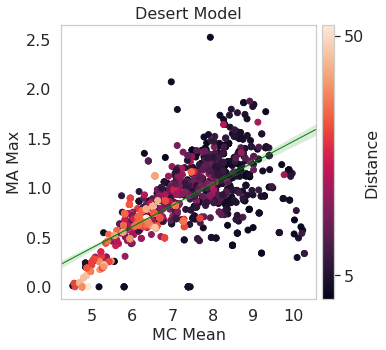

In [111]:
f,ax=plt.subplots(1,1,figsize=(5.5,5))
ax.grid(False)
dat=traindf
v1=dat.mc_mean
v2=dat.st_mean
v3=dat.distance
var1 = ax.scatter(v1,v2, c=v3)

ax.set_title('Desert Model')
g1 = sns.regplot(x=v1,y=v2 , data=dat,
            ax=ax, line_kws={'color':'green','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

ax.set_xlabel('MC Mean')
ax.set_ylabel('MA Max')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical',ticks=[5,50])
cbar.solids.set(alpha=1)
cbar.ax.set_ylabel('Distance', rotation=90, labelpad=0)
# f.suptitle('$R^2$ and AIC for Desert')
figurefirst.mpl_functions.set_fontsize(f, 16)
# ax.text(4.5,10,'$R^2=0.027',color='blue',fontsize=10)
f.tight_layout(pad=1)

# f.savefig('../../Figure/MC_stmean.jpeg', dpi=300, bbox_inches = "tight")

### Low pass filtering


In [6]:
x = pd.read_hdf('~/DataAnalysis/data/Sprints/'+'LpfAnalysis/desert_1.0.h5')
len(x)

764

In [ ]:
cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
lookback_time = 10
rs=[]
for i in range(len(cutoff)):
    desert = pd.concat([fdf_notwindy,fdf_windy])
    desert.reset_index(inplace=True, drop=True)
    trainset= low_pass_filter(desert,cutoff[i]) 
    # testset = fdf_forest

    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []


    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,
                                                                                        distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

    def calc_val(X):
        return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
    #     return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),np.median(X),stats.mode(X[0])[0][0]])
    column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
                 'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
                 'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
                 'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
                 'st_min','st_max','st_mean','st_std_dev','st_k']

    ## Done separately because Forest dataset has two classes
    ## Training set
    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
    traindf['nwhiffs'] = np.delete(Nrows_train, c1)



    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

    rs.append(distance.f_pvalue)



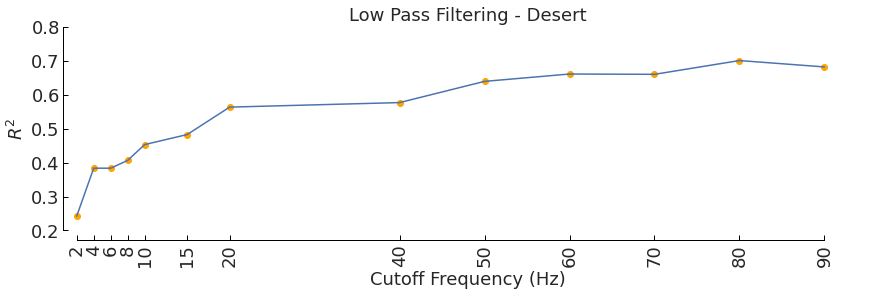

In [10]:
# cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40,50,60,70,80,90])
# rsq=rs
# rsq=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,0.24205416850966,
#              0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
#              0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
#              0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])

rsq=np.array([0.24205416850966,
             0.38348641665523975,0.38348641665523975,0.4064829597057922,0.45311169229618875,
             0.4826627957203161,0.5635516377812952, 0.5769321356148331,0.6394535507195294,
             0.6611420518231501,0.6602473760004987,0.7008459671212011,0.682043273913716])
rsq1=np.array([0.6203130980463978,0.3745363995992592,0.327073395020676, 0.2814948909942232,
              0.24205416850966])
cutoff=np.array([2,4,6,8,10,15,20,40,50,60,70,80,90])
cutoff1=np.array([0.1,0.2,0.5,1,2])
f,ax=plt.subplots(1,1,figsize=(12,4))
ax.plot(cutoff,rsq)
# ax.plot(cutoff1,rsq1,'--',c='b')
ax.scatter(cutoff,rsq,c='orange')
# ax.scatter(cutoff1,rsq1,c='orange')
ax.grid(False)
ax.set_xlabel('Cutoff Frequency (Hz)')
ax.set_ylabel('$R^2$')
ax.set_xlim(1.6,)

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[2,4,6,8,10,15,20,40,50,60,70,80,90],
#                             yticks = [-0.01,0.01],
                            linewidth=1)

plt.xticks(rotation=90)
ax.set_title('Low Pass Filtering - Desert')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/LPF_OnCont.jpeg', dpi=300, bbox_inches = "tight")

### Code for generating R2 vs LT plots 

In [ ]:
t=[0.5,1,2,3,4,5,8,10,20]
r =[]

def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

desert = pd.concat([fdf_notwindy,fdf_windy, fdf_forest])
desert.reset_index(inplace=True, drop=True)
trainset= desert 

for i in range(len(t)):

    lookback_time = t[i]

  
    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []

    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)

     
    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)

    traindf['distance']=np.delete(D_train, c1)
    traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
    traindf['nwhiffs'] = np.delete(Nrows_train, c1)
    
    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k+nwhiffs""", data=traindf).fit()

    r.append(distance.rsquared)

In [ ]:
# def get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters):
#     y=dataframe_cont.iloc[same_time_location]
#     A = y.time.round(0) - duration_of_encounters
#     B = y.time.round(0)
#     timed_rows_cont = dataframe_cont.loc[(dataframe_cont.time > A) & (dataframe_cont.time < B)]
     
#     return np.mean(timed_rows_cont.odor)

# def get_timed_rows(dataframe,dataframe_cont,duration_of_encounters):
#     x = dataframe.sample(1)
#     A = x.mean_time.values.round(0) - duration_of_encounters
#     B = x.mean_time.values.round(0)

#     if (np.where(dataframe_cont.time.round(0)==B[0])[0].size == 0):
#         #find index of closest value in continuous data frame
#         same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]     
#     else:
#         same_time_location = np.where(dataframe_cont.time.round(0) == B[0])[0][0]
#     same_time_location = dataframe_cont.iloc[(dataframe_cont['time']-B[0]).abs().argsort()[:1]].index[0]
#     timed_rows_odor_mean = get_timed_rows_cont(same_time_location,dataframe_cont,duration_of_encounters)
#     timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
#     return timed_rows,timed_rows_odor_mean
    
# def get_timed_encounter_stats(dataframe,dataframe_cont, distance_class, duration_of_encounters):
#     df_q = dataframe.query('type == ' + str(distance_class))   
#     df_q.reset_index(inplace=True, drop=True)     
        
#     df_q_cont = dataframe_cont.query('type == ' + str(distance_class))   
#     df_q_cont.reset_index(inplace=True, drop=True)     
    
#     Nrows,mean_conc = get_timed_rows(df_q,df_q_cont,duration_of_encounters)
#     avg_dist = np.mean(Nrows.avg_dist_from_source)
#     mean_time_whiff=np.mean(Nrows.mean_time)
# #     mean_conc=np.mean(Nrows_cont.odor)
#     pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
#     return pack_data,avg_dist,len(Nrows),mean_time_whiff,mean_conc


# def gather_stat_timed(dataframe,dataframe_cont, distance_class, duration_of_encounters,X,y,D,N,T,MC):
#     for i in range(500):
#         xx,dx,n,t,mc=get_timed_encounter_stats(dataframe, dataframe_cont,
#                                                distance_class, duration_of_encounters)
#         X.append(xx)
#         D.append(dx)
#         y.append(distance_class)
#         N.append(n)
#         T.append(t)
#         MC.append(mc)

#     return X,y,D,N,T,MC
